# AnoGAN
<hr/>

#### parameter
- 2020.08.16
> latent_size = 100  
> workers = 4 
> img_size = 64  
> channel = 1  
> epochs = 100  
> batch_size = 64  
> **learning_rate = 1e-5  
> learning_G_per_D = 1**


# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
# data_root = "../../dataset/train"
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# Model

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 1)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3835 / G_loss : 0.6872
- D(x) : 0.5050 / D(G(z1)) : 0.5035 / D(G(z2)) : 0.5030
[1/100][1/14]
- D_loss : 1.3807 / G_loss : 0.6865
- D(x) : 0.5067 / D(G(z1)) : 0.5038 / D(G(z2)) : 0.5034
[1/100][2/14]
- D_loss : 1.3813 / G_loss : 0.6869
- D(x) : 0.5061 / D(G(z1)) : 0.5036 / D(G(z2)) : 0.5031
[1/100][3/14]
- D_loss : 1.3794 / G_loss : 0.6869
- D(x) : 0.5071 / D(G(z1)) : 0.5036 / D(G(z2)) : 0.5032
[1/100][4/14]
- D_loss : 1.3789 / G_loss : 0.6868
- D(x) : 0.5074 / D(G(z1)) : 0.5036 / D(G(z2)) : 0.5032
[1/100][5/14]
- D_loss : 1.3786 / G_loss : 0.6872
- D(x) : 0.5074 / D(G(z1)) : 0.5034 / D(G(z2)) : 0.5030
[1/100][6/14]
- D_loss : 1.3784 / G_loss : 0.6862
- D(x) : 0.5081 / D(G(z1)) : 0.5040 / D(G(z2)) : 0.5035
[1/100][7/14]
- D_loss : 1.3752 / G_loss : 0.6869
- D(x) : 0.5093 / D(G(z1)) : 0.5036 / D(G(z2)) : 0.5031
[1/100][8/14]
- D_loss : 1.3759 / G_loss : 0.6878
- D(x) : 0.5085 / D(G(z1)) : 0.5032 / D(G(z2)) : 0.5027
[1/100][9/14]
- D_loss : 1.3748 / G_loss : 0.6

[6/100][8/14]
- D_loss : 1.2306 / G_loss : 0.7503
- D(x) : 0.5558 / D(G(z1)) : 0.4741 / D(G(z2)) : 0.4722
[6/100][9/14]
- D_loss : 1.2265 / G_loss : 0.7514
- D(x) : 0.5575 / D(G(z1)) : 0.4737 / D(G(z2)) : 0.4717
[6/100][10/14]
- D_loss : 1.2222 / G_loss : 0.7535
- D(x) : 0.5588 / D(G(z1)) : 0.4727 / D(G(z2)) : 0.4707
[6/100][11/14]
- D_loss : 1.2168 / G_loss : 0.7574
- D(x) : 0.5600 / D(G(z1)) : 0.4709 / D(G(z2)) : 0.4689
[6/100][12/14]
- D_loss : 1.2118 / G_loss : 0.7607
- D(x) : 0.5613 / D(G(z1)) : 0.4694 / D(G(z2)) : 0.4674
[6/100][13/14]
- D_loss : 1.2047 / G_loss : 0.7630
- D(x) : 0.5643 / D(G(z1)) : 0.4684 / D(G(z2)) : 0.4663
[7/100][0/14]
- D_loss : 1.2005 / G_loss : 0.7658
- D(x) : 0.5652 / D(G(z1)) : 0.4671 / D(G(z2)) : 0.4650
[7/100][1/14]
- D_loss : 1.1956 / G_loss : 0.7678
- D(x) : 0.5670 / D(G(z1)) : 0.4662 / D(G(z2)) : 0.4640
[7/100][2/14]
- D_loss : 1.1957 / G_loss : 0.7715
- D(x) : 0.5652 / D(G(z1)) : 0.4645 / D(G(z2)) : 0.4623
[7/100][3/14]
- D_loss : 1.2006 / G_loss :

[12/100][4/14]
- D_loss : 0.8251 / G_loss : 1.0993
- D(x) : 0.6597 / D(G(z1)) : 0.3353 / D(G(z2)) : 0.3331
[12/100][5/14]
- D_loss : 0.8193 / G_loss : 1.1045
- D(x) : 0.6620 / D(G(z1)) : 0.3335 / D(G(z2)) : 0.3314
[12/100][6/14]
- D_loss : 0.8126 / G_loss : 1.1092
- D(x) : 0.6648 / D(G(z1)) : 0.3319 / D(G(z2)) : 0.3298
[12/100][7/14]
- D_loss : 0.8149 / G_loss : 1.1139
- D(x) : 0.6616 / D(G(z1)) : 0.3303 / D(G(z2)) : 0.3283
[12/100][8/14]
- D_loss : 0.7983 / G_loss : 1.1174
- D(x) : 0.6715 / D(G(z1)) : 0.3292 / D(G(z2)) : 0.3271
[12/100][9/14]
- D_loss : 0.7874 / G_loss : 1.1221
- D(x) : 0.6771 / D(G(z1)) : 0.3277 / D(G(z2)) : 0.3256
[12/100][10/14]
- D_loss : 0.7911 / G_loss : 1.1265
- D(x) : 0.6735 / D(G(z1)) : 0.3262 / D(G(z2)) : 0.3242
[12/100][11/14]
- D_loss : 0.7947 / G_loss : 1.1319
- D(x) : 0.6691 / D(G(z1)) : 0.3244 / D(G(z2)) : 0.3224
[12/100][12/14]
- D_loss : 0.7878 / G_loss : 1.1372
- D(x) : 0.6723 / D(G(z1)) : 0.3227 / D(G(z2)) : 0.3207
[12/100][13/14]
- D_loss : 0.7881 

[17/100][13/14]
- D_loss : 0.5572 / G_loss : 1.4110
- D(x) : 0.7590 / D(G(z1)) : 0.2450 / D(G(z2)) : 0.2439
[18/100][0/14]
- D_loss : 0.5662 / G_loss : 1.4136
- D(x) : 0.7515 / D(G(z1)) : 0.2444 / D(G(z2)) : 0.2433
[18/100][1/14]
- D_loss : 0.5574 / G_loss : 1.4176
- D(x) : 0.7573 / D(G(z1)) : 0.2434 / D(G(z2)) : 0.2423
[18/100][2/14]
- D_loss : 0.5506 / G_loss : 1.4213
- D(x) : 0.7615 / D(G(z1)) : 0.2425 / D(G(z2)) : 0.2414
[18/100][3/14]
- D_loss : 0.5510 / G_loss : 1.4243
- D(x) : 0.7604 / D(G(z1)) : 0.2418 / D(G(z2)) : 0.2407
[18/100][4/14]
- D_loss : 0.5534 / G_loss : 1.4284
- D(x) : 0.7576 / D(G(z1)) : 0.2408 / D(G(z2)) : 0.2397
[18/100][5/14]
- D_loss : 0.5497 / G_loss : 1.4307
- D(x) : 0.7599 / D(G(z1)) : 0.2402 / D(G(z2)) : 0.2392
[18/100][6/14]
- D_loss : 0.5461 / G_loss : 1.4339
- D(x) : 0.7619 / D(G(z1)) : 0.2395 / D(G(z2)) : 0.2384
[18/100][7/14]
- D_loss : 0.5386 / G_loss : 1.4372
- D(x) : 0.7667 / D(G(z1)) : 0.2387 / D(G(z2)) : 0.2376
[18/100][8/14]
- D_loss : 0.5487 / G

[23/100][8/14]
- D_loss : 0.4213 / G_loss : 1.6449
- D(x) : 0.8142 / D(G(z1)) : 0.1939 / D(G(z2)) : 0.1930
[23/100][9/14]
- D_loss : 0.4184 / G_loss : 1.6476
- D(x) : 0.8160 / D(G(z1)) : 0.1934 / D(G(z2)) : 0.1925
[23/100][10/14]
- D_loss : 0.4178 / G_loss : 1.6510
- D(x) : 0.8159 / D(G(z1)) : 0.1927 / D(G(z2)) : 0.1919
[23/100][11/14]
- D_loss : 0.4181 / G_loss : 1.6528
- D(x) : 0.8152 / D(G(z1)) : 0.1924 / D(G(z2)) : 0.1915
[23/100][12/14]
- D_loss : 0.4162 / G_loss : 1.6560
- D(x) : 0.8161 / D(G(z1)) : 0.1918 / D(G(z2)) : 0.1909
[23/100][13/14]
- D_loss : 0.4126 / G_loss : 1.6592
- D(x) : 0.8184 / D(G(z1)) : 0.1911 / D(G(z2)) : 0.1903
[24/100][0/14]
- D_loss : 0.4163 / G_loss : 1.6616
- D(x) : 0.8151 / D(G(z1)) : 0.1907 / D(G(z2)) : 0.1898
[24/100][1/14]
- D_loss : 0.4128 / G_loss : 1.6642
- D(x) : 0.8173 / D(G(z1)) : 0.1902 / D(G(z2)) : 0.1894
[24/100][2/14]
- D_loss : 0.4131 / G_loss : 1.6667
- D(x) : 0.8167 / D(G(z1)) : 0.1897 / D(G(z2)) : 0.1889
[24/100][3/14]
- D_loss : 0.4056 

[29/100][2/14]
- D_loss : 0.3320 / G_loss : 1.8494
- D(x) : 0.8522 / D(G(z1)) : 0.1580 / D(G(z2)) : 0.1573
[29/100][3/14]
- D_loss : 0.3396 / G_loss : 1.8526
- D(x) : 0.8453 / D(G(z1)) : 0.1575 / D(G(z2)) : 0.1568
[29/100][4/14]
- D_loss : 0.3328 / G_loss : 1.8552
- D(x) : 0.8506 / D(G(z1)) : 0.1571 / D(G(z2)) : 0.1564
[29/100][5/14]
- D_loss : 0.3310 / G_loss : 1.8573
- D(x) : 0.8518 / D(G(z1)) : 0.1567 / D(G(z2)) : 0.1561
[29/100][6/14]
- D_loss : 0.3298 / G_loss : 1.8599
- D(x) : 0.8523 / D(G(z1)) : 0.1563 / D(G(z2)) : 0.1557
[29/100][7/14]
- D_loss : 0.3333 / G_loss : 1.8614
- D(x) : 0.8491 / D(G(z1)) : 0.1561 / D(G(z2)) : 0.1555
[29/100][8/14]
- D_loss : 0.3242 / G_loss : 1.8648
- D(x) : 0.8564 / D(G(z1)) : 0.1556 / D(G(z2)) : 0.1549
[29/100][9/14]
- D_loss : 0.3240 / G_loss : 1.8659
- D(x) : 0.8564 / D(G(z1)) : 0.1554 / D(G(z2)) : 0.1548
[29/100][10/14]
- D_loss : 0.3366 / G_loss : 1.8696
- D(x) : 0.8451 / D(G(z1)) : 0.1548 / D(G(z2)) : 0.1542
[29/100][11/14]
- D_loss : 0.3248 / 

[34/100][12/14]
- D_loss : 0.2681 / G_loss : 2.0388
- D(x) : 0.8800 / D(G(z1)) : 0.1308 / D(G(z2)) : 0.1302
[34/100][13/14]
- D_loss : 0.2740 / G_loss : 2.0401
- D(x) : 0.8747 / D(G(z1)) : 0.1307 / D(G(z2)) : 0.1300
[35/100][0/14]
- D_loss : 0.2710 / G_loss : 2.0420
- D(x) : 0.8770 / D(G(z1)) : 0.1304 / D(G(z2)) : 0.1298
[35/100][1/14]
- D_loss : 0.2728 / G_loss : 2.0448
- D(x) : 0.8750 / D(G(z1)) : 0.1300 / D(G(z2)) : 0.1294
[35/100][2/14]
- D_loss : 0.2681 / G_loss : 2.0459
- D(x) : 0.8791 / D(G(z1)) : 0.1299 / D(G(z2)) : 0.1293
[35/100][3/14]
- D_loss : 0.2666 / G_loss : 2.0507
- D(x) : 0.8798 / D(G(z1)) : 0.1293 / D(G(z2)) : 0.1287
[35/100][4/14]
- D_loss : 0.2672 / G_loss : 2.0530
- D(x) : 0.8789 / D(G(z1)) : 0.1290 / D(G(z2)) : 0.1284
[35/100][5/14]
- D_loss : 0.2661 / G_loss : 2.0552
- D(x) : 0.8796 / D(G(z1)) : 0.1287 / D(G(z2)) : 0.1281
[35/100][6/14]
- D_loss : 0.2643 / G_loss : 2.0566
- D(x) : 0.8810 / D(G(z1)) : 0.1285 / D(G(z2)) : 0.1279
[35/100][7/14]
- D_loss : 0.2642 / 

[40/100][5/14]
- D_loss : 0.2234 / G_loss : 2.2154
- D(x) : 0.8984 / D(G(z1)) : 0.1097 / D(G(z2)) : 0.1091
[40/100][6/14]
- D_loss : 0.2275 / G_loss : 2.2163
- D(x) : 0.8946 / D(G(z1)) : 0.1096 / D(G(z2)) : 0.1090
[40/100][7/14]
- D_loss : 0.2269 / G_loss : 2.2189
- D(x) : 0.8949 / D(G(z1)) : 0.1093 / D(G(z2)) : 0.1087
[40/100][8/14]
- D_loss : 0.2212 / G_loss : 2.2232
- D(x) : 0.8995 / D(G(z1)) : 0.1089 / D(G(z2)) : 0.1083
[40/100][9/14]
- D_loss : 0.2211 / G_loss : 2.2248
- D(x) : 0.8995 / D(G(z1)) : 0.1087 / D(G(z2)) : 0.1081
[40/100][10/14]
- D_loss : 0.2213 / G_loss : 2.2280
- D(x) : 0.8988 / D(G(z1)) : 0.1083 / D(G(z2)) : 0.1077
[40/100][11/14]
- D_loss : 0.2203 / G_loss : 2.2318
- D(x) : 0.8993 / D(G(z1)) : 0.1079 / D(G(z2)) : 0.1073
[40/100][12/14]
- D_loss : 0.2234 / G_loss : 2.2328
- D(x) : 0.8964 / D(G(z1)) : 0.1078 / D(G(z2)) : 0.1072
[40/100][13/14]
- D_loss : 0.2200 / G_loss : 2.2357
- D(x) : 0.8992 / D(G(z1)) : 0.1075 / D(G(z2)) : 0.1069
[41/100][0/14]
- D_loss : 0.2179 

[45/100][13/14]
- D_loss : 0.1880 / G_loss : 2.3751
- D(x) : 0.9141 / D(G(z1)) : 0.0935 / D(G(z2)) : 0.0930
[46/100][0/14]
- D_loss : 0.1919 / G_loss : 2.3766
- D(x) : 0.9104 / D(G(z1)) : 0.0933 / D(G(z2)) : 0.0929
[46/100][1/14]
- D_loss : 0.1923 / G_loss : 2.3791
- D(x) : 0.9098 / D(G(z1)) : 0.0931 / D(G(z2)) : 0.0926
[46/100][2/14]
- D_loss : 0.1896 / G_loss : 2.3813
- D(x) : 0.9120 / D(G(z1)) : 0.0929 / D(G(z2)) : 0.0924
[46/100][3/14]
- D_loss : 0.1883 / G_loss : 2.3837
- D(x) : 0.9130 / D(G(z1)) : 0.0926 / D(G(z2)) : 0.0922
[46/100][4/14]
- D_loss : 0.1856 / G_loss : 2.3859
- D(x) : 0.9152 / D(G(z1)) : 0.0924 / D(G(z2)) : 0.0920
[46/100][5/14]
- D_loss : 0.1833 / G_loss : 2.3885
- D(x) : 0.9171 / D(G(z1)) : 0.0922 / D(G(z2)) : 0.0918
[46/100][6/14]
- D_loss : 0.1854 / G_loss : 2.3915
- D(x) : 0.9149 / D(G(z1)) : 0.0919 / D(G(z2)) : 0.0915
[46/100][7/14]
- D_loss : 0.1870 / G_loss : 2.3947
- D(x) : 0.9131 / D(G(z1)) : 0.0916 / D(G(z2)) : 0.0912
[46/100][8/14]
- D_loss : 0.1855 / G

[51/100][6/14]
- D_loss : 0.1601 / G_loss : 2.5428
- D(x) : 0.9251 / D(G(z1)) : 0.0790 / D(G(z2)) : 0.0787
[51/100][7/14]
- D_loss : 0.1605 / G_loss : 2.5436
- D(x) : 0.9247 / D(G(z1)) : 0.0789 / D(G(z2)) : 0.0786
[51/100][8/14]
- D_loss : 0.1596 / G_loss : 2.5454
- D(x) : 0.9254 / D(G(z1)) : 0.0788 / D(G(z2)) : 0.0785
[51/100][9/14]
- D_loss : 0.1590 / G_loss : 2.5481
- D(x) : 0.9258 / D(G(z1)) : 0.0786 / D(G(z2)) : 0.0782
[51/100][10/14]
- D_loss : 0.1576 / G_loss : 2.5514
- D(x) : 0.9268 / D(G(z1)) : 0.0783 / D(G(z2)) : 0.0780
[51/100][11/14]
- D_loss : 0.1569 / G_loss : 2.5533
- D(x) : 0.9273 / D(G(z1)) : 0.0782 / D(G(z2)) : 0.0778
[51/100][12/14]
- D_loss : 0.1599 / G_loss : 2.5554
- D(x) : 0.9244 / D(G(z1)) : 0.0780 / D(G(z2)) : 0.0777
[51/100][13/14]
- D_loss : 0.1561 / G_loss : 2.5573
- D(x) : 0.9277 / D(G(z1)) : 0.0779 / D(G(z2)) : 0.0775
[52/100][0/14]
- D_loss : 0.1566 / G_loss : 2.5605
- D(x) : 0.9271 / D(G(z1)) : 0.0776 / D(G(z2)) : 0.0773
[52/100][1/14]
- D_loss : 0.1566 

[57/100][0/14]
- D_loss : 0.1373 / G_loss : 2.6872
- D(x) : 0.9357 / D(G(z1)) : 0.0684 / D(G(z2)) : 0.0681
[57/100][1/14]
- D_loss : 0.1368 / G_loss : 2.6894
- D(x) : 0.9360 / D(G(z1)) : 0.0683 / D(G(z2)) : 0.0680
[57/100][2/14]
- D_loss : 0.1365 / G_loss : 2.6930
- D(x) : 0.9361 / D(G(z1)) : 0.0680 / D(G(z2)) : 0.0677
[57/100][3/14]
- D_loss : 0.1376 / G_loss : 2.6901
- D(x) : 0.9352 / D(G(z1)) : 0.0682 / D(G(z2)) : 0.0679
[57/100][4/14]
- D_loss : 0.1375 / G_loss : 2.6916
- D(x) : 0.9353 / D(G(z1)) : 0.0681 / D(G(z2)) : 0.0678
[57/100][5/14]
- D_loss : 0.1361 / G_loss : 2.6916
- D(x) : 0.9366 / D(G(z1)) : 0.0681 / D(G(z2)) : 0.0678
[57/100][6/14]
- D_loss : 0.1357 / G_loss : 2.6952
- D(x) : 0.9367 / D(G(z1)) : 0.0678 / D(G(z2)) : 0.0676
[57/100][7/14]
- D_loss : 0.1338 / G_loss : 2.6971
- D(x) : 0.9383 / D(G(z1)) : 0.0678 / D(G(z2)) : 0.0674
[57/100][8/14]
- D_loss : 0.1356 / G_loss : 2.6984
- D(x) : 0.9366 / D(G(z1)) : 0.0677 / D(G(z2)) : 0.0674
[57/100][9/14]
- D_loss : 0.1343 / G_

[62/100][7/14]
- D_loss : 0.1185 / G_loss : 2.7989
- D(x) : 0.9462 / D(G(z1)) : 0.0612 / D(G(z2)) : 0.0609
[62/100][8/14]
- D_loss : 0.1218 / G_loss : 2.8007
- D(x) : 0.9429 / D(G(z1)) : 0.0611 / D(G(z2)) : 0.0608
[62/100][9/14]
- D_loss : 0.1210 / G_loss : 2.8006
- D(x) : 0.9437 / D(G(z1)) : 0.0611 / D(G(z2)) : 0.0608
[62/100][10/14]
- D_loss : 0.1191 / G_loss : 2.8023
- D(x) : 0.9453 / D(G(z1)) : 0.0610 / D(G(z2)) : 0.0607
[62/100][11/14]
- D_loss : 0.1181 / G_loss : 2.8033
- D(x) : 0.9462 / D(G(z1)) : 0.0609 / D(G(z2)) : 0.0606
[62/100][12/14]
- D_loss : 0.1186 / G_loss : 2.8048
- D(x) : 0.9457 / D(G(z1)) : 0.0608 / D(G(z2)) : 0.0605
[62/100][13/14]
- D_loss : 0.1180 / G_loss : 2.8073
- D(x) : 0.9461 / D(G(z1)) : 0.0607 / D(G(z2)) : 0.0604
[63/100][0/14]
- D_loss : 0.1186 / G_loss : 2.8083
- D(x) : 0.9455 / D(G(z1)) : 0.0606 / D(G(z2)) : 0.0603
[63/100][1/14]
- D_loss : 0.1171 / G_loss : 2.8102
- D(x) : 0.9468 / D(G(z1)) : 0.0605 / D(G(z2)) : 0.0602
[63/100][2/14]
- D_loss : 0.1217 

[68/100][0/14]
- D_loss : 0.1041 / G_loss : 2.9334
- D(x) : 0.9521 / D(G(z1)) : 0.0536 / D(G(z2)) : 0.0532
[68/100][1/14]
- D_loss : 0.1056 / G_loss : 2.9348
- D(x) : 0.9506 / D(G(z1)) : 0.0535 / D(G(z2)) : 0.0532
[68/100][2/14]
- D_loss : 0.1043 / G_loss : 2.9362
- D(x) : 0.9518 / D(G(z1)) : 0.0534 / D(G(z2)) : 0.0531
[68/100][3/14]
- D_loss : 0.1059 / G_loss : 2.9408
- D(x) : 0.9500 / D(G(z1)) : 0.0531 / D(G(z2)) : 0.0529
[68/100][4/14]
- D_loss : 0.1042 / G_loss : 2.9396
- D(x) : 0.9517 / D(G(z1)) : 0.0532 / D(G(z2)) : 0.0529
[68/100][5/14]
- D_loss : 0.1030 / G_loss : 2.9450
- D(x) : 0.9525 / D(G(z1)) : 0.0529 / D(G(z2)) : 0.0526
[68/100][6/14]
- D_loss : 0.1035 / G_loss : 2.9451
- D(x) : 0.9520 / D(G(z1)) : 0.0529 / D(G(z2)) : 0.0526
[68/100][7/14]
- D_loss : 0.1025 / G_loss : 2.9455
- D(x) : 0.9530 / D(G(z1)) : 0.0529 / D(G(z2)) : 0.0526
[68/100][8/14]
- D_loss : 0.1024 / G_loss : 2.9504
- D(x) : 0.9528 / D(G(z1)) : 0.0526 / D(G(z2)) : 0.0523
[68/100][9/14]
- D_loss : 0.1003 / G_

[73/100][8/14]
- D_loss : 0.0930 / G_loss : 3.0666
- D(x) : 0.9559 / D(G(z1)) : 0.0468 / D(G(z2)) : 0.0466
[73/100][9/14]
- D_loss : 0.0907 / G_loss : 3.0679
- D(x) : 0.9581 / D(G(z1)) : 0.0467 / D(G(z2)) : 0.0466
[73/100][10/14]
- D_loss : 0.0938 / G_loss : 3.0710
- D(x) : 0.9549 / D(G(z1)) : 0.0465 / D(G(z2)) : 0.0464
[73/100][11/14]
- D_loss : 0.0928 / G_loss : 3.0727
- D(x) : 0.9558 / D(G(z1)) : 0.0465 / D(G(z2)) : 0.0463
[73/100][12/14]
- D_loss : 0.0914 / G_loss : 3.0727
- D(x) : 0.9571 / D(G(z1)) : 0.0465 / D(G(z2)) : 0.0463
[73/100][13/14]
- D_loss : 0.0896 / G_loss : 3.0771
- D(x) : 0.9587 / D(G(z1)) : 0.0463 / D(G(z2)) : 0.0461
[74/100][0/14]
- D_loss : 0.0880 / G_loss : 3.0789
- D(x) : 0.9602 / D(G(z1)) : 0.0463 / D(G(z2)) : 0.0460
[74/100][1/14]
- D_loss : 0.0916 / G_loss : 3.0806
- D(x) : 0.9567 / D(G(z1)) : 0.0462 / D(G(z2)) : 0.0460
[74/100][2/14]
- D_loss : 0.0911 / G_loss : 3.0832
- D(x) : 0.9570 / D(G(z1)) : 0.0460 / D(G(z2)) : 0.0459
[74/100][3/14]
- D_loss : 0.0890 

[79/100][2/14]
- D_loss : 0.0816 / G_loss : 3.1975
- D(x) : 0.9611 / D(G(z1)) : 0.0411 / D(G(z2)) : 0.0409
[79/100][3/14]
- D_loss : 0.0812 / G_loss : 3.1995
- D(x) : 0.9614 / D(G(z1)) : 0.0410 / D(G(z2)) : 0.0408
[79/100][4/14]
- D_loss : 0.0793 / G_loss : 3.2015
- D(x) : 0.9631 / D(G(z1)) : 0.0409 / D(G(z2)) : 0.0407
[79/100][5/14]
- D_loss : 0.0805 / G_loss : 3.2016
- D(x) : 0.9620 / D(G(z1)) : 0.0409 / D(G(z2)) : 0.0407
[79/100][6/14]
- D_loss : 0.0801 / G_loss : 3.2025
- D(x) : 0.9623 / D(G(z1)) : 0.0408 / D(G(z2)) : 0.0407
[79/100][7/14]
- D_loss : 0.0806 / G_loss : 3.2040
- D(x) : 0.9618 / D(G(z1)) : 0.0408 / D(G(z2)) : 0.0406
[79/100][8/14]
- D_loss : 0.0792 / G_loss : 3.2068
- D(x) : 0.9631 / D(G(z1)) : 0.0407 / D(G(z2)) : 0.0405
[79/100][9/14]
- D_loss : 0.0783 / G_loss : 3.2084
- D(x) : 0.9639 / D(G(z1)) : 0.0407 / D(G(z2)) : 0.0405
[79/100][10/14]
- D_loss : 0.0799 / G_loss : 3.2106
- D(x) : 0.9622 / D(G(z1)) : 0.0405 / D(G(z2)) : 0.0404
[79/100][11/14]
- D_loss : 0.0799 / 

[84/100][10/14]
- D_loss : 0.0725 / G_loss : 3.3205
- D(x) : 0.9651 / D(G(z1)) : 0.0363 / D(G(z2)) : 0.0362
[84/100][11/14]
- D_loss : 0.0712 / G_loss : 3.3225
- D(x) : 0.9663 / D(G(z1)) : 0.0362 / D(G(z2)) : 0.0361
[84/100][12/14]
- D_loss : 0.0699 / G_loss : 3.3247
- D(x) : 0.9675 / D(G(z1)) : 0.0362 / D(G(z2)) : 0.0360
[84/100][13/14]
- D_loss : 0.0698 / G_loss : 3.3267
- D(x) : 0.9675 / D(G(z1)) : 0.0361 / D(G(z2)) : 0.0359
[85/100][0/14]
- D_loss : 0.0701 / G_loss : 3.3287
- D(x) : 0.9672 / D(G(z1)) : 0.0360 / D(G(z2)) : 0.0359
[85/100][1/14]
- D_loss : 0.0699 / G_loss : 3.3297
- D(x) : 0.9672 / D(G(z1)) : 0.0360 / D(G(z2)) : 0.0358
[85/100][2/14]
- D_loss : 0.0691 / G_loss : 3.3313
- D(x) : 0.9680 / D(G(z1)) : 0.0359 / D(G(z2)) : 0.0358
[85/100][3/14]
- D_loss : 0.0709 / G_loss : 3.3316
- D(x) : 0.9662 / D(G(z1)) : 0.0359 / D(G(z2)) : 0.0358
[85/100][4/14]
- D_loss : 0.0702 / G_loss : 3.3340
- D(x) : 0.9668 / D(G(z1)) : 0.0358 / D(G(z2)) : 0.0357
[85/100][5/14]
- D_loss : 0.0704 

[90/100][5/14]
- D_loss : 0.0615 / G_loss : 3.4358
- D(x) : 0.9718 / D(G(z1)) : 0.0323 / D(G(z2)) : 0.0322
[90/100][6/14]
- D_loss : 0.0631 / G_loss : 3.4381
- D(x) : 0.9701 / D(G(z1)) : 0.0322 / D(G(z2)) : 0.0321
[90/100][7/14]
- D_loss : 0.0632 / G_loss : 3.4393
- D(x) : 0.9700 / D(G(z1)) : 0.0322 / D(G(z2)) : 0.0321
[90/100][8/14]
- D_loss : 0.0621 / G_loss : 3.4411
- D(x) : 0.9710 / D(G(z1)) : 0.0322 / D(G(z2)) : 0.0321
[90/100][9/14]
- D_loss : 0.0628 / G_loss : 3.4409
- D(x) : 0.9704 / D(G(z1)) : 0.0322 / D(G(z2)) : 0.0321
[90/100][10/14]
- D_loss : 0.0629 / G_loss : 3.4429
- D(x) : 0.9701 / D(G(z1)) : 0.0321 / D(G(z2)) : 0.0320
[90/100][11/14]
- D_loss : 0.0620 / G_loss : 3.4430
- D(x) : 0.9710 / D(G(z1)) : 0.0321 / D(G(z2)) : 0.0320
[90/100][12/14]
- D_loss : 0.0613 / G_loss : 3.4450
- D(x) : 0.9717 / D(G(z1)) : 0.0320 / D(G(z2)) : 0.0319
[90/100][13/14]
- D_loss : 0.0612 / G_loss : 3.4458
- D(x) : 0.9718 / D(G(z1)) : 0.0320 / D(G(z2)) : 0.0319
[91/100][0/14]
- D_loss : 0.0633 

[96/100][0/14]
- D_loss : 0.0553 / G_loss : 3.5561
- D(x) : 0.9742 / D(G(z1)) : 0.0287 / D(G(z2)) : 0.0286
[96/100][1/14]
- D_loss : 0.0546 / G_loss : 3.5567
- D(x) : 0.9748 / D(G(z1)) : 0.0287 / D(G(z2)) : 0.0285
[96/100][2/14]
- D_loss : 0.0552 / G_loss : 3.5581
- D(x) : 0.9742 / D(G(z1)) : 0.0286 / D(G(z2)) : 0.0285
[96/100][3/14]
- D_loss : 0.0555 / G_loss : 3.5601
- D(x) : 0.9738 / D(G(z1)) : 0.0285 / D(G(z2)) : 0.0284
[96/100][4/14]
- D_loss : 0.0571 / G_loss : 3.5604
- D(x) : 0.9722 / D(G(z1)) : 0.0285 / D(G(z2)) : 0.0284
[96/100][5/14]
- D_loss : 0.0556 / G_loss : 3.5603
- D(x) : 0.9737 / D(G(z1)) : 0.0285 / D(G(z2)) : 0.0284
[96/100][6/14]
- D_loss : 0.0557 / G_loss : 3.5615
- D(x) : 0.9736 / D(G(z1)) : 0.0285 / D(G(z2)) : 0.0284
[96/100][7/14]
- D_loss : 0.0555 / G_loss : 3.5632
- D(x) : 0.9738 / D(G(z1)) : 0.0284 / D(G(z2)) : 0.0284
[96/100][8/14]
- D_loss : 0.0548 / G_loss : 3.5618
- D(x) : 0.9745 / D(G(z1)) : 0.0285 / D(G(z2)) : 0.0284
[96/100][9/14]
- D_loss : 0.0547 / G_

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

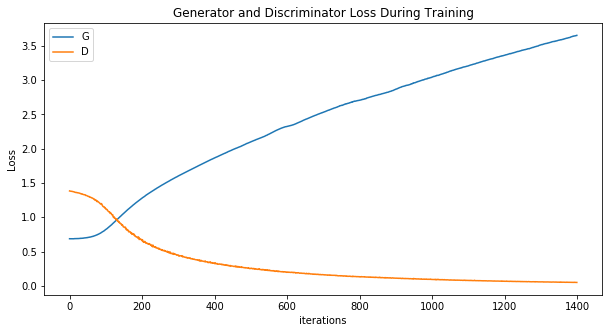

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

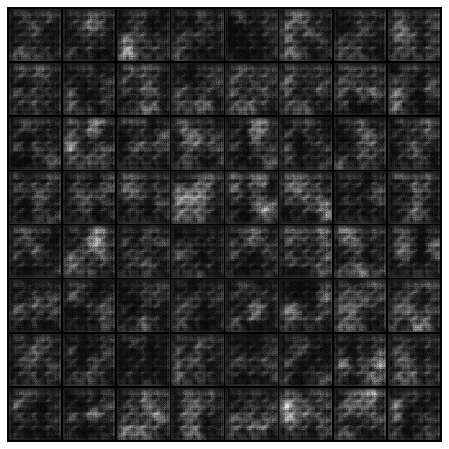

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature =  D(Test_Data)
    _, G_Data_feature    =  D(G_Data)
    residual_loss        =  torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss  =  torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss             =  (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_Ti64"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 910.5469  Sum_of_z : -9.9461
[200]	 Ano_loss : 856.5089  Sum_of_z : -5.1667
[400]	 Ano_loss : 850.7025  Sum_of_z : -11.3309
picture  2
[0]	 Ano_loss : 1671.4520  Sum_of_z : -11.4451
[200]	 Ano_loss : 1621.0605  Sum_of_z : -11.9601
[400]	 Ano_loss : 1617.4939  Sum_of_z : -12.7439
picture  3
[0]	 Ano_loss : 1458.9808  Sum_of_z : -13.0713
[200]	 Ano_loss : 1390.8623  Sum_of_z : -17.7350
[400]	 Ano_loss : 1387.7732  Sum_of_z : -14.7655
picture  4
[0]	 Ano_loss : 1598.6373  Sum_of_z : -14.3912
[200]	 Ano_loss : 1542.5685  Sum_of_z : 13.0201
[400]	 Ano_loss : 1537.0848  Sum_of_z : 13.9131
picture  5
[0]	 Ano_loss : 1506.2382  Sum_of_z : 14.2841
[200]	 Ano_loss : 1416.3030  Sum_of_z : 14.9956
[400]	 Ano_loss : 1415.3092  Sum_of_z : 14.6751
picture  6
[0]	 Ano_loss : 1775.6835  Sum_of_z : 14.7271
[200]	 Ano_loss : 1690.0632  Sum_of_z : 12.3374
[400]	 Ano_loss : 1685.6671  Sum_of_z : 12.0746
picture  7
[0]	 Ano_loss : 664.2887  Sum_of_z : 12.0505
[200]	 Ano_loss : 623

# Similar Z , Ano_Score and Segementation

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

In [16]:
diff_cnts = []

def compare_imgs(real_img, generated_img,i, reverse=False, threshold=50):
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

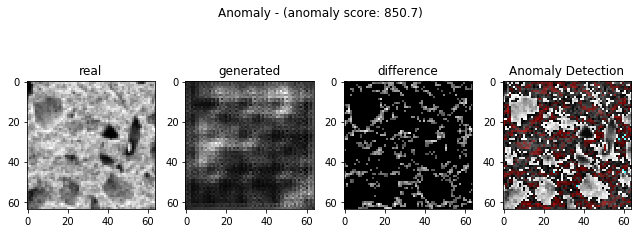

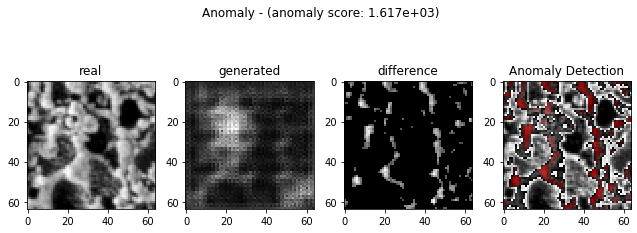

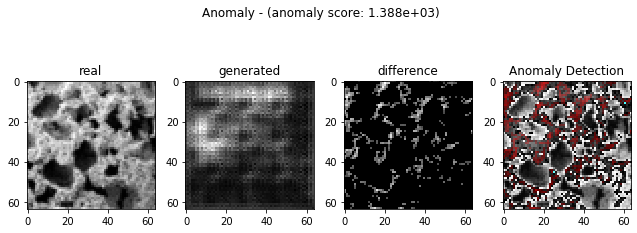

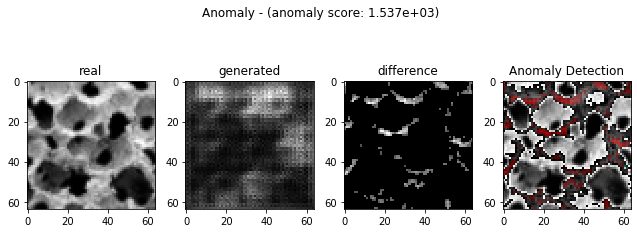

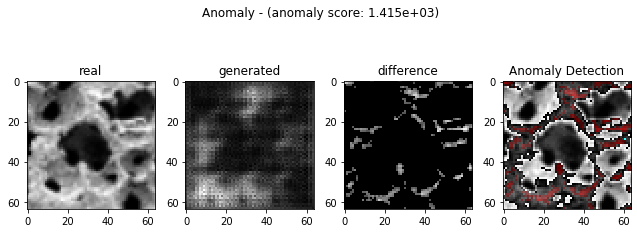

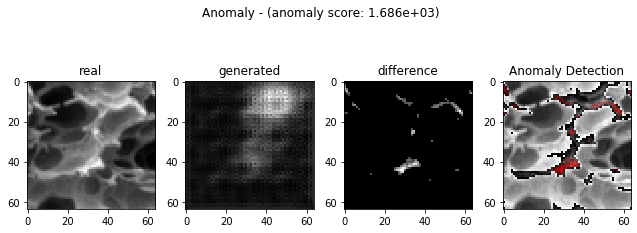

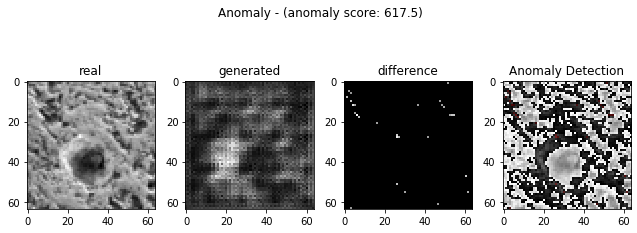

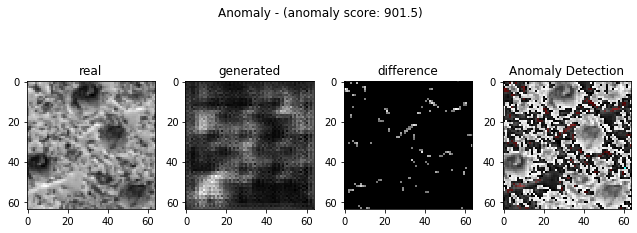

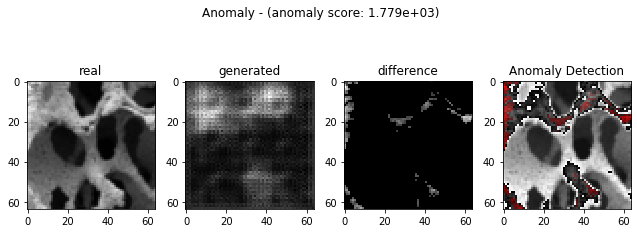

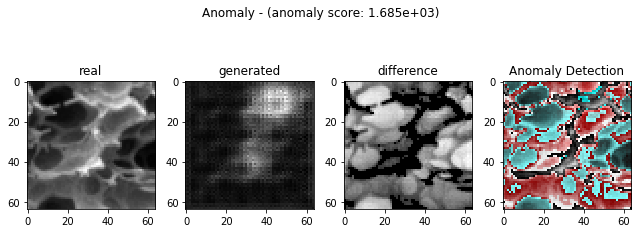

In [17]:
vali_label = [0,0,0,0,0,1,1,1,1,1,1]

for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

# AnoGAN 성능 확인: 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.22363281 0.13476562 0.15673828 0.10375977 0.11181641 0.03222656
 0.00683594 0.03344727 0.06030273 0.77563477]


In [19]:
# 분율 평균
print(sum(diff_fraction)/len(diff_fraction))

0.163916015625


In [1]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

NameError: name 'np' is not defined